# Positive Predictive Value (PPV) Comparison Across Modalities

### Objective

Compare **PPV across all imaging modalities** to evaluate relative diagnostic accuracy.

### Data Source

- `side_concordance_results.xlsx` (pre-operative imaging and surgical outcomes)

### Outputs

| **Modality** | **PPV** |
|--------------|---------|
| SPECT/CT | 92.1% |
| 4D CT Scan | 85.4% |
| Ultrasound | 85.9% |
| Sestamibi | 99.1% |
| MRI | 75.0% |

---

In [1]:
import pandas as pd 
preop_imaging_df = pd.read_excel('../../Data/side_concordance_results.xlsx')

In [2]:
def extract_side(location):
    if pd.isnull(location):
        return 'No Scan'
    
    if 'Left' in location:
        return 'Left'
    elif 'Right' in location:
        return 'Right'
    else:
        return 'Unknown'
    
preop_imaging_df['Surgical Side'] = preop_imaging_df['Surgical_Findings'].apply(extract_side)


In [3]:
# Define modality
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

# Apply extract_side function to get imaging sides
for modality in modalities:
    imaging_side_col = modality + ' Imaging Side'
    preop_imaging_df[imaging_side_col] = preop_imaging_df[modality].apply(extract_side)

In [4]:
# Calculate concordance for each modality
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'

    def check_concordance(row):
        imaging = row[modality]
        surgical = row['Surgical_Findings']
        
        if pd.isnull(imaging) or pd.isnull(surgical):
            return 'Unknown'
        imaging_glands = [g.strip() for g in imaging.split(',')]
        surgical_glands = [g.strip() for g in surgical.split(',')]
        
        if any(sg in imaging_glands for sg in surgical_glands):
            return 'Yes (Exact)'
        
        imaging_sides = []
        for ig in imaging_glands:
            if 'Left' in ig:
                imaging_sides.append('Left')
            if 'Right' in ig:
                imaging_sides.append('Right')
        
        surgical_sides = []
        for sg in surgical_glands:
            if 'Left' in sg:
                surgical_sides.append('Left')
            if 'Right' in sg:
                surgical_sides.append('Right')
        
        if any(side in surgical_sides for side in imaging_sides):
            return 'Yes (Side)'
        
        return 'Incorrect Localization'

    # Apply to DataFrame within the loop for each modality
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(check_concordance, axis=1)

In [6]:
ppv_dict = {}

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    imaging_side_col = modality + ' Imaging Side'
    
    localized_df = preop_imaging_df[preop_imaging_df[imaging_side_col].isin(['Left', 'Right'])].copy()
    
    true_positive = (
        (localized_df[concordance_col] == 'Yes (Exact)') |
        (localized_df[concordance_col] == 'Yes (Side)')
    ).sum()
    
    false_positive = (localized_df[concordance_col] == 'Incorrect Localization').sum()
    ppv = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else None
    ppv_dict[modality] = ppv
    
ppv_df = pd.DataFrame(list(ppv_dict.items()), columns=['Modality', 'PPV'])
ppv_df

,Modality,PPV
0,SPECT/CT,0.920904
1,4D CT Scan,0.853801
2,Ultrasound,0.858974
3,Sestamibi,0.991150
4,MRI,0.750000


In [7]:
import matplotlib.pyplot as plt

ppv_df['PPV (%)'] = ppv_df['PPV'].apply(lambda x: x * 100 if x is not None else None)

sorted_ppv_df = ppv_df.sort_values(by='PPV (%)', ascending=False)

# Define color palette 
colors = plt.cm.Set2(range(len(sorted_ppv_df)))

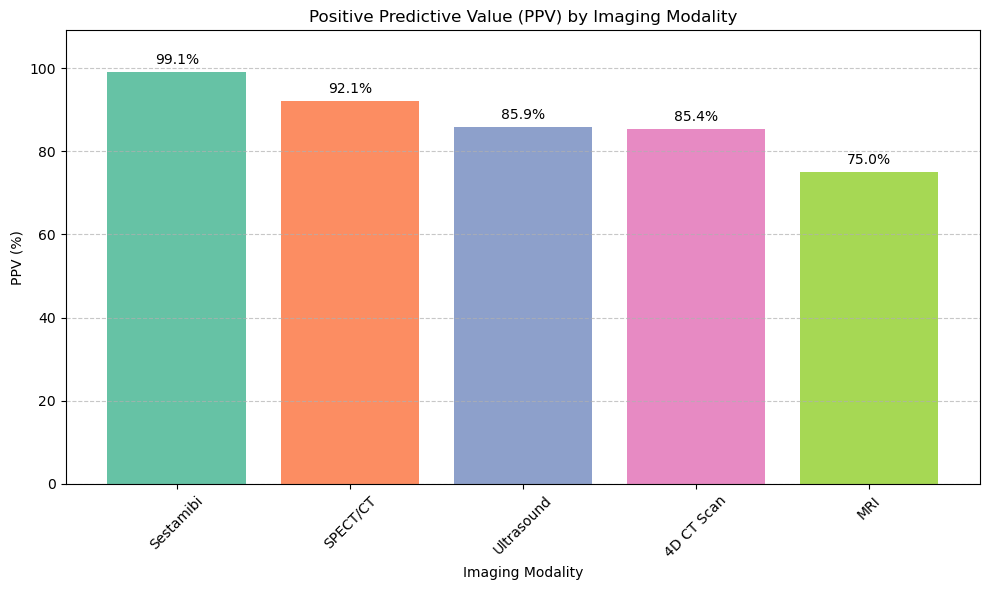

In [8]:
# Create figure and bar plot
plt.figure(figsize=(10,6))
plt.bar(sorted_ppv_df['Modality'], sorted_ppv_df['PPV (%)'], color=colors)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for i, v in enumerate(sorted_ppv_df['PPV (%)']):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=10)
    
plt.title('Positive Predictive Value (PPV) by Imaging Modality')
plt.ylabel('PPV (%)')
plt.xlabel('Imaging Modality')


# Adjust y-axis limits for breathing room
plt.ylim(0, sorted_ppv_df['PPV (%)'].max() + 10)


# Rotate x-axis labels for clarity
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


---

### Interpretation

- **Sestamibi scans** demonstrated the highest PPV (99.1%), indicating excellent localization accuracy when positive.
- **SPECT/CT** also showed strong PPV (92.1%).
- **4D CT** and **Ultrasound** had comparable PPVs (~85%).
- **MRI** showed the lowest PPV (75%), reflecting its limited standalone localization accuracy in this cohort.